# Movie Recommendation System using TensorFlow

## Data Source
The dataset used for this analysis is sourced from [Kaggle](https://www.kaggle.com/code/faiqueali/tensorflow-movie-recommender-system). It contains user interactions with movies, including ratings, which we use to build a recommendation system.

## Problem Statement
Recommendation systems are essential in modern digital platforms like streaming services, e-commerce, and social media. This project aims to build a **movie recommendation system** using TensorFlow to provide personalized movie suggestions based on user preferences. We will leverage collaborative filtering techniques to predict user ratings for movies.

## Proposed Solution
We will use TensorFlow to create a recommendation system following these steps:
1. **Data Exploration**: Understand the structure of the data, explore trends, and identify features.
2. **Data Preprocessing**: Prepare the data for machine learning by encoding, scaling, and splitting.
3. **Model Building**: Implement a recommendation model using collaborative filtering techniques.
4. **Evaluation**: Assess the model's performance using metrics like RMSE and suggest potential improvements.

## Step 1: Data Exploration

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
ratings = pd.read_csv('ratings_small.csv') 
movies = pd.read_csv('movies_metadata.csv', low_memory = False).drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).drop([19730, 29503, 35587])  

In [2]:
# Display first few rows of the dataset
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [3]:
# Display first few rows of the dataset
movies.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0


### Observations
We will examine the structure of the dataset and identify any missing or anomalous values.

## Step 2: Data Preprocessing

In [4]:
# Data preprocessing steps
# 1. Merge datasets to combine movie titles with ratings.

# Ensure consistent data types for 'movieId'
ratings['movieId'] = ratings['movieId'].astype(str)
movies['movieId'] = movies['id'].astype(str)

# Merge the datasets
data = ratings.merge(movies, on='movieId')


In [5]:
# 2. Encode userId and movieId as categorical data.
data['userId'] = data['userId'].astype('category').cat.codes
data['movieId'] = data['movieId'].astype('category').cat.codes

In [6]:
# 3. Split data into training and testing sets.
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)

## Step 3: Model Building

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout

# Number of unique users and movies
num_users = data['userId'].nunique()
num_movies = data['movieId'].nunique()

# Embedding dimensions
embedding_dim = 50

### Input Layers

We create input layers for both users and movies:
- User Input: Accepts a single value representing the user ID.
- Movie Input: Accepts a single value representing the movie ID.

Why?: Inputs serve as the entry points for user and movie data into the model.

In [8]:
user_input = Input(shape=(1,), name="User_Input")
movie_input = Input(shape=(1,), name="Movie_Input")

### Embedding Layers
We add embedding layers to map users and movies into latent feature spaces:
- User Embedding: Maps the user ID to a dense vector representation of embedding_dim size.
- Movie Embedding: Maps the movie ID to a dense vector representation of embedding_dim size.

Why?: Embeddings capture latent factors, such as user preferences and movie characteristics, which are crucial for recommendations.

In [9]:
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name="User_Embedding")(user_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_dim, name="Movie_Embedding")(movie_input)

### Bias Terms
We add embeddings for user and movie biases to capture global effects:
- User Bias: Represents how a specific user tends to rate movies (e.g., some users rate higher or lower on average).
- Movie Bias: Represents the general popularity of a movie (e.g., some movies receive consistently high ratings).

Why?: Bias terms help the model account for systematic differences in user and movie behaviors.

In [10]:
user_bias = Embedding(input_dim=num_users, output_dim=1, name="User_Bias")(user_input)
movie_bias = Embedding(input_dim=num_movies, output_dim=1, name="Movie_Bias")(movie_input)

### Flatten the Embedding Outputs
We flatten the embeddings to prepare them for further operations.

Why?: Flattening converts the embedding outputs from multi-dimensional tensors to a single vector, enabling subsequent operations like dot products and concatenations.

In [11]:
user_vector = Flatten(name="User_Vector")(user_embedding)
movie_vector = Flatten(name="Movie_Vector")(movie_embedding)

### Dot Product
We calculate the dot product of the user and movie embeddings.

Why?: The dot product estimates the interaction between a user and a movie, forming the basis of collaborative filtering.

In [12]:
dot_product = Dot(axes=1, name="Dot_Product")([user_vector, movie_vector])

### Add Bias Terms
We add the user and movie biases to the dot product.

Why?: Adding biases adjusts the dot product score to reflect user and movie-specific tendencies.

In [13]:
add_bias = tf.keras.layers.Add(name="Add_Bias")([dot_product, Flatten()(user_bias), Flatten()(movie_bias)])

### Dense Layers
We add fully connected (dense) layers to model non-linear interactions:
- Dense Layer 1: Captures higher-level patterns with 128 units and a ReLU activation function.
- Dropout Layer 1: Prevents overfitting by randomly deactivating 30% of the neurons during training.
- Dense Layer 2: Further refines patterns with 64 units and ReLU activation.
- Dropout Layer 2: Applies dropout again to enhance regularization.

Why?: Dense layers introduce the capacity to model complex, non-linear relationships between users and movies.

In [14]:
dense_1 = Dense(128, activation='relu', name="Dense_1")(add_bias)
dropout_1 = Dropout(0.3, name="Dropout_1")(dense_1)
dense_2 = Dense(64, activation='relu', name="Dense_2")(dropout_1)
dropout_2 = Dropout(0.3, name="Dropout_2")(dense_2)

### Output Layer
We add a dense layer with a single output neuron to predict the final rating.

Why?: The output layer generates a single value (the predicted rating) for the user-movie pair.

In [15]:
output = Dense(1, activation='linear', name="Output")(dropout_2)

### Compile the Model
We compile the model with:

- Optimizer: Adam, for efficient training.
- Loss Function: Mean Squared Error (MSE), to minimize the prediction error.
- Metric: Mean Absolute Error (MAE), to measure the average prediction error.

Why?: Compiling finalizes the model setup, specifying how it will learn and how performance will be evaluated.

In [16]:
model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

### Model Summary
We print the model architecture to understand its structure.

Why?: Reviewing the model summary helps verify the layers and their connections.

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ User_Input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Movie_Input (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User_Embedding (Embedding)    │ (None, 1, 50)             │          33,550 │ User_Input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Movie_Embedding (Embedding)   │ (None, 1, 50)             │         141,500 │ Movie_Input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User_Vector (Flatten)         │ (None, 50)                │               0 │ User_Embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Movie_Vector (Flatten)        │ (None, 50)                │               0 │ Movie_Embedding[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User_Bias (Embedding)         │ (None, 1, 1)              │             671 │ User_Input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Movie_Bias (Embedding)        │ (None, 1, 1)              │           2,830 │ Movie_Input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dot_Product (Dot)             │ (None, 1)                 │               0 │ User_Vector[0][0],         │
│                               │                           │                 │ Movie_Vector[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 1)                 │               0 │ User_Bias[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 1)                 │               0 │ Movie_Bias[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Add_Bias (Add)                │ (None, 1)                 │               0 │ Dot_Product[0][0],         │
│                               │                           │                 │ flatten[0][0],             │
│                               │                           │                 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dense_1 (Dense)               │ (None, 128)               │             256 │ Add_Bias[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dropout_1 (Dropout)           │ (None, 128)               │               0 │ Dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dense_2 (Dense)               │ (None, 64)                │           8,256 │ Dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dropout_2 (Dropout)           │ (None, 64)                │               

 Total params: 187,128 (730.97 KB)

 Trainable params: 187,128 (730.97 KB)

 Non-trainable params: 0 (0.00 B)

## Step 4: Model Training and Evaluation

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.8950 - mae: 1.5025 - val_loss: 0.8658 - val_mae: 0.7270
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8275 - mae: 0.7141 - val_loss: 0.8631 - val_mae: 0.7242
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5283 - mae: 0.5725 - val_loss: 0.9114 - val_mae: 0.7390
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3992 - mae: 0.4989 - val_loss: 0.9363 - val_mae: 0.7471
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3245 - mae: 0.4508 - val_loss: 0.9467 - val_mae: 0.7504
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2701 - mae: 0.4102 - val_loss: 0.9695 - val_mae: 0.7535
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2341 - mae: 0.3814 - val_loss: 0.9774 - val_mae: 0.7651
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2134 - mae: 0.3621 - val_loss: 0.9918 - val_mae: 0.7676
Epoch 9/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

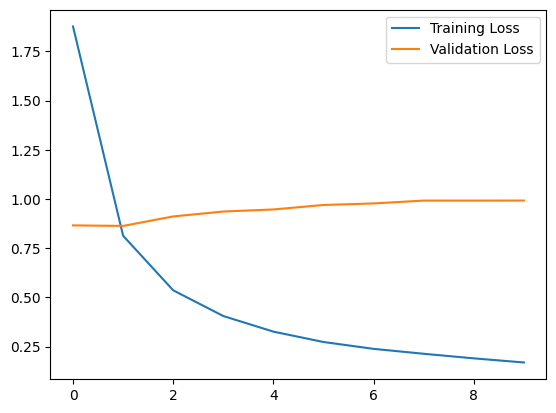

In [18]:
# Train the model
history = model.fit(
    x=[train['userId'], train['movieId']],
    y=train['rating'],
    epochs=10,
    batch_size=64,
    validation_data=(
        [test['userId'], test['movieId']], test['rating']
    )
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

## Step 5: Results and Discussion
We will analyze the training and validation losses to determine the model's effectiveness. Potential improvements, such as adding regularization or increasing embedding dimensions, will be discussed.

## Movie recommendation for specific user

In [22]:
import numpy as np
import pandas as pd

# Assuming the following variables:
# - model: The trained recommendation model
# - movie_data: DataFrame containing movieId and movie titles
# - train_data: DataFrame containing userId and movieId
# - userId = 5

# Step 1: Get all movie IDs (list of all movies that were used during training)
all_movie_ids = train['movieId'].unique()

# Step 2: Prepare the input data (userId = 5, all movieIds)
user_input = np.full(len(all_movie_ids), 5)  # User input: Repeated '5' for all movies
movie_input = all_movie_ids  # Movie input: List of all movie IDs

# Step 3: Make predictions for all movies for userId = 5
predictions = model.predict([user_input, movie_input])

# Step 4: Convert predictions to DataFrame for easier processing
predictions_df = pd.DataFrame({
    'movieId': all_movie_ids,
    'predicted_rating': predictions.flatten()  # Flatten the prediction result to 1D array
})

# Step 5: Merge with movie data to get movie titles
recommendations = predictions_df.merge(data, on='movieId', how='left')

# Step 6: Sort predictions in descending order of predicted ratings
recommendations = recommendations.sort_values(by='predicted_rating', ascending=False)

# Step 7: Get the top N movie recommendations (e.g., top 10)
top_n_recommendations = recommendations[['movieId', 'original_title','predicted_rating']].head(10)

# Step 8: Display the top N recommended movies
print(top_n_recommendations)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
      movieId original_title  predicted_rating
7928     2087        Солярис          4.915082
7828     2087        Солярис          4.915082
7838     2087        Солярис          4.915082
7837     2087        Солярис          4.915082
7836     2087        Солярис          4.915082
7824     2087        Солярис          4.915082
7825     2087        Солярис          4.915082
7826     2087        Солярис          4.915082
7827     2087        Солярис          4.915082
7829     2087        Солярис          4.915082


## Conclusion
This project demonstrated the implementation of a movie recommendation system using TensorFlow. The system leverages collaborative filtering to predict user ratings for movies, showing the potential of machine learning in enhancing user experiences in digital platforms.